In [17]:
!pip install yfinance numpy pandas scikit-learn tensorflow matplotlib  

import yfinance as yf #yahoo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import datetime



[*********************100%***********************]  1 of 1 completed


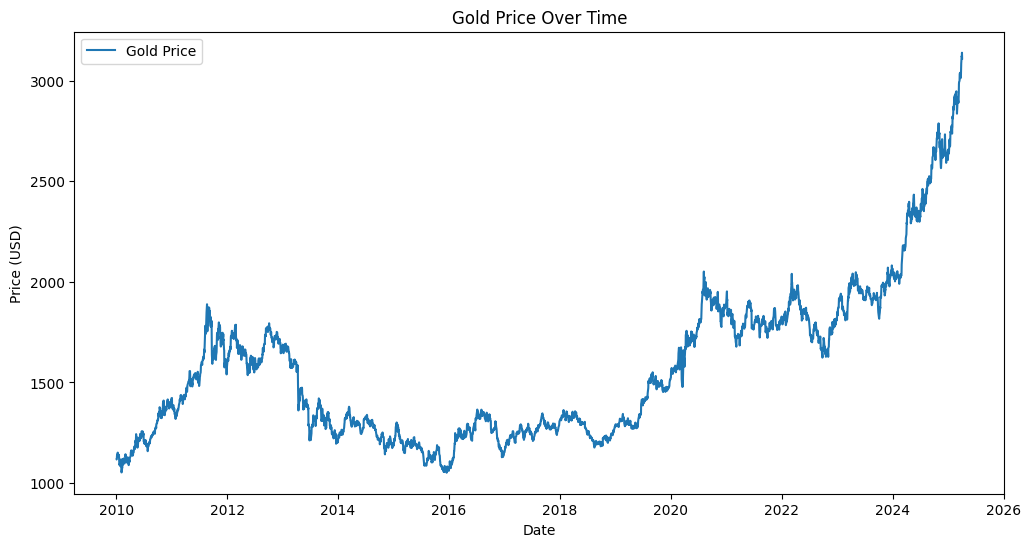

In [18]:
today = datetime.today().strftime('%Y-%m-%d')

symbol = "GC=F"  # Gold futures ticke
start_date = "2010-01-01"

gold_data = yf.download(symbol, start=start_date, end=today)
gold_prices = gold_data[['Close']].dropna()
# to plot
plt.figure(figsize=(12, 6))
plt.plot(gold_prices, label="Gold Price")
plt.title("Gold Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend() # line rep
plt.show()


In [28]:
# Nor data
scaler = MinMaxScaler(feature_range=(0, 1))
gold_prices_scaled = scaler.fit_transform(gold_prices) # we are appling scaler to this gold prise data


In [29]:
# Convert into sequences for LSTM
def create_sequences(data, seq_length):
    sequences, labels = [], []  # Stores 60-day historical data and traget value 
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

sequence_length = 60
X, y = create_sequences(gold_prices_scaled, sequence_length)


In [21]:
# Split data
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [25]:
# Define LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/25


C:\Users\Ranjita Biradar\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0082 - val_loss: 0.0018
Epoch 2/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 6.9800e-04 - val_loss: 0.0014
Epoch 3/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 6.0490e-04 - val_loss: 0.0035
Epoch 4/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 5.1232e-04 - val_loss: 8.3552e-04
Epoch 5/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 5.1906e-04 - val_loss: 0.0012
Epoch 6/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 4.9097e-04 - val_loss: 0.0029
Epoch 7/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 5.1044e-04 - val_loss: 0.0027
Epoch 8/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 3.5784e-04 - val_loss: 8.6115e-04
Epoch 9/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 3.4584e-04 - val_loss: 0.0012
Epoch 10/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 3.3021e-04 - val_loss: 0.0012
Epoch 11/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 3.4085e-04 - val_loss: 4.0161e-04
Epoch 12/25
95/95 ━━━

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step


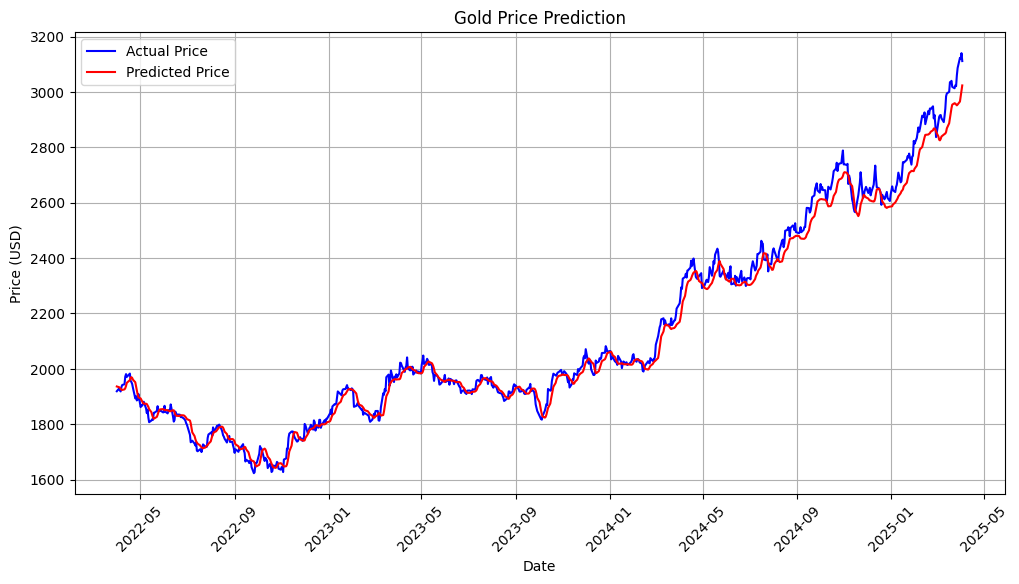

In [26]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

test_dates = gold_prices.index[train_size + sequence_length:]  # Extract dates for test data

# Plot actual vs. predicted prices with date labels
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_original, label="Actual Price", color='blue')
plt.plot(test_dates, predictions, label="Predicted Price", color='red')
plt.title("Gold Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid()
plt.show()


In [27]:
# Predict next day's price
last_60_days = gold_prices_scaled[-60:].reshape(1, 60, 1)
future_price_scaled = model.predict(last_60_days)
future_price = scaler.inverse_transform(future_price_scaled.reshape(-1, 1))

print(f"📢 Predicted Gold Price for the Next Day: ${future_price[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
📢 Predicted Gold Price for the Next Day: $3034.78


In [58]:
from sklearn.metrics import mean_squared_error , r2_score
y_predict=model.predict(X_test)
mse = mean_squared_error(y_test,y_predict)
print("mse",mse)#
rs2= r2_score(y_test,y_predict)
print(rs2)# 

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
mse 0.0003731725185196094
0.9879071895331749
